<a href="https://colab.research.google.com/github/lucasbaldezzari/babesbayes-nma/blob/seoheehan94-patch-1/Laquitaine%26Gardner_Population_model_Seohee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span> <font color='3A40A2'>Bayes babes: Laquitaine & Gardner - Population model</font> </span>


In [2]:
#@title importing libraries
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
#@title Define parameters
motion_coherence = [0.06, 0.12, 0.24]
prior_std = [10, 20, 40, 80]
prior_kappa = [33.3, 8.7, 2.8, 0.7] # kappa(concentration) from prior_std in radians
mean_direction_deg = 225  # mean direction in degrees
num_trials = 1000  # example number of trials

In [ ]:
#print(np.deg2rad(10))
#print(1/(np.deg2rad(10))**2)
#prior_kappa = [1.0 / (np.deg2rad(std) ** 2) for std in prior_std]
#print(prior_kappa) # similar enough I guess...

In [4]:
#@title generate inputs

# Generate direction values from Von Mises distribution
def generate_von_mises_data(kappa, num_trials, mean_direction_deg):
  """
    Args:
    kappa: concentration parameter of the Von Mises distribution.
    num_trials: number of trials
    mean_direction_degree: mean direction in degreess.

    Returns:
    array of sampled directions.
  """
  # Convert mean direction to radians
  mean_direction_rad = np.deg2rad(mean_direction_deg)

  # Generate direction values from Von Mises distribution
  directions_rad = stats.vonmises.rvs(kappa, loc=mean_direction_rad, size=num_trials)

  return directions_rad


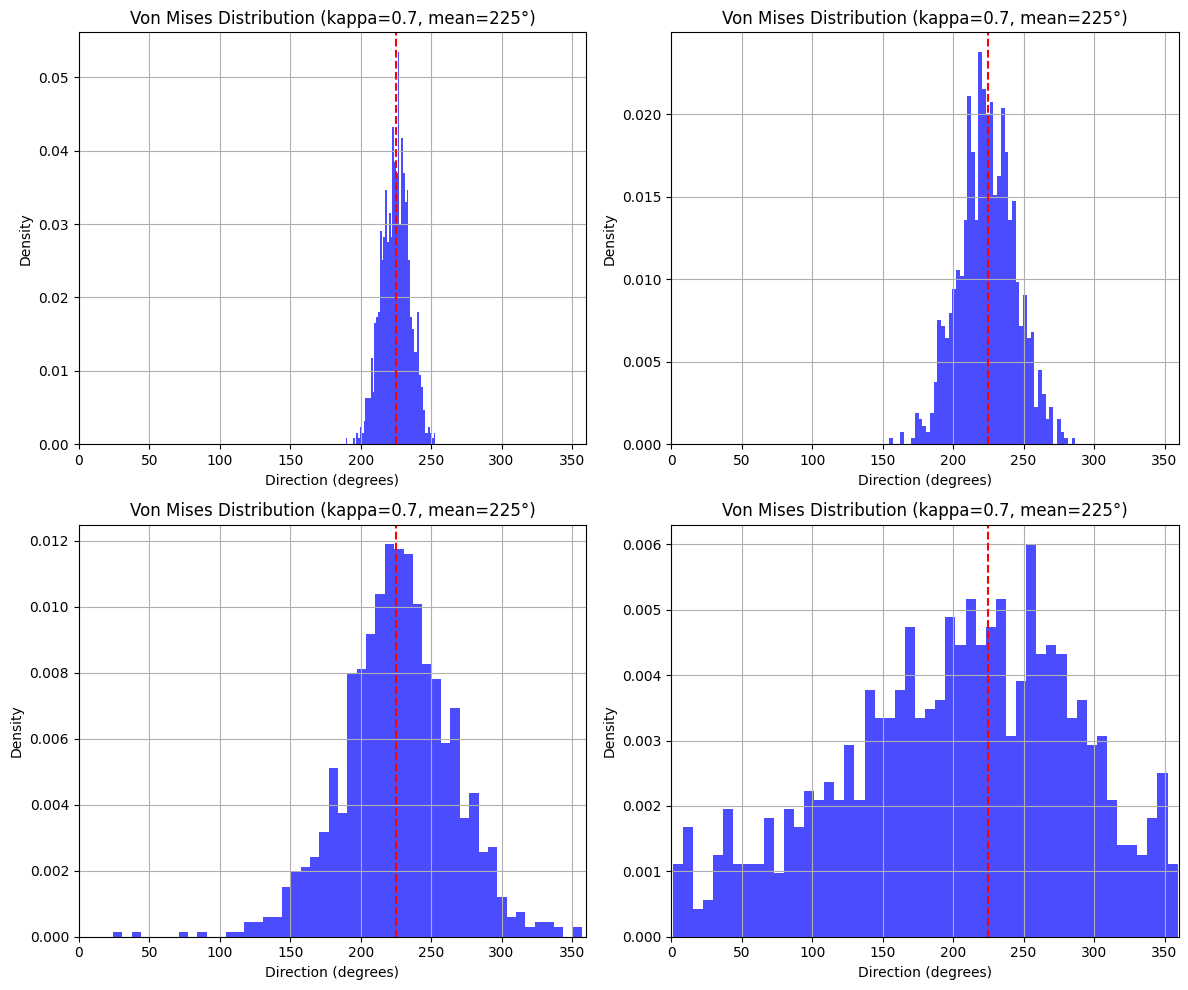

In [37]:
#@title plot the sample input distribution

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Generate and plot data for each concentration
for i, kappa in enumerate(prior_kappa):
    directions_rad = generate_von_mises_data(kappa, num_trials, mean_direction_deg)

    # Convert directions back to degrees
    directions_deg = np.rad2deg(directions_rad) % 360

    # Plot histogram on the respective subplot
    row = i // 2
    col = i % 2
    axs[row, col].hist(directions_deg, bins=50, density=True, alpha=0.7, color='blue')
    axs[row, col].set_title(f'Von Mises Distribution (kappa={concentration}, mean={mean_direction_deg}°)')
    axs[row, col].set_xlabel('Direction (degrees)')
    axs[row, col].set_ylabel('Density')
    axs[row, col].grid(True)
    axs[row, col].set_xlim([0, 360])
    axs[row, col].axvline(x=225, color='red', linestyle='--')

# Adjust layout
plt.tight_layout()
plt.show()

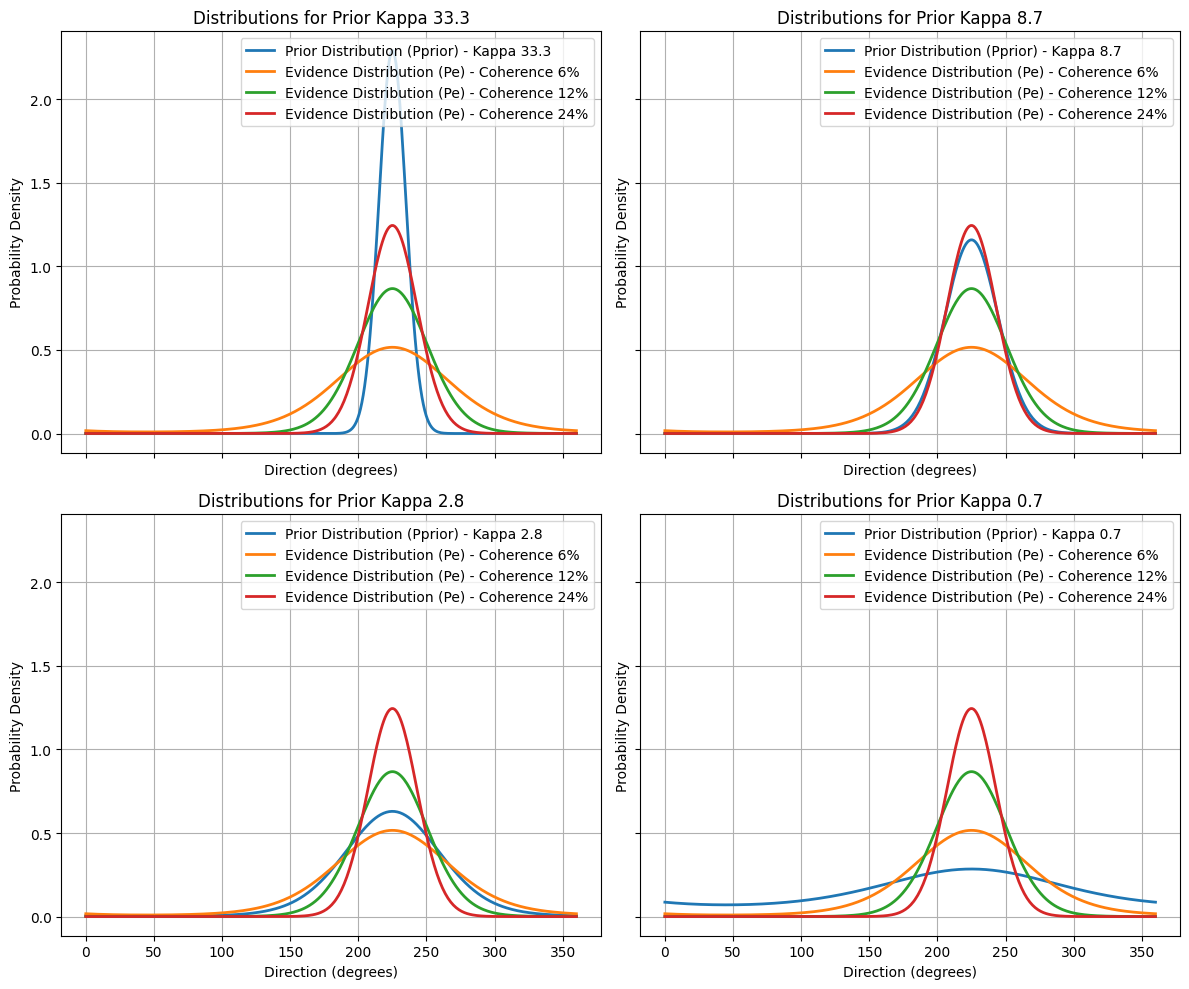

In [22]:
#@title Generate prior and sensory distribution
# Parameters
mean_direction_rad = np.deg2rad(mean_direction_deg)  # Prior mean in radians
coherence_to_kappa = {
    0.06: 2,
    0.12: 5,
    0.24: 10
} # random kappa assigned for now
# Number of samples
n_samples = 1000

# Function to generate Von Mises distributed data
def von_mises_pdf(kappa, mean_direction_rad):
    x = np.linspace(0, 2*np.pi, 360)
    y = stats.vonmises.pdf(x, kappa, loc=mean_direction_rad)
    x_deg = np.rad2deg(x)
    return x_deg, y

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

for idx, kappa in enumerate(prior_kappa):
    row = idx // 2
    col = idx % 2

    # Plot prior distribution
    x_deg, y = von_mises_pdf(kappa, mean_direction_rad)
    axs[row, col].plot(x_deg, y, label=f'Prior Distribution (Pprior) - Kappa {kappa}', linewidth=2)

    # Plot evidence distributions
    for coherence, kappa_evidence in coherence_to_kappa.items():
        x_deg, y = von_mises_pdf(kappa_evidence, mean_direction_rad)
        axs[row, col].plot(x_deg, y, label=f'Evidence Distribution (Pe) - Coherence {coherence*100:.0f}%', linewidth=2)

    axs[row, col].set_title(f'Distributions for Prior Kappa {kappa}')
    axs[row, col].set_xlabel('Direction (degrees)')
    axs[row, col].set_ylabel('Probability Density')
    axs[row, col].grid(True)
    axs[row, col].legend()

plt.tight_layout()
plt.show()

In [25]:
#@title Implement the Switching Heuristic Model

def switching_model(directions_rad, motion_coherence, mean_direction_rad, prior_kappa):
    """
    Simulate the switching heuristic model with a prior distribution.

    Args:
    directions_rad: array of input directions in radians.
    motion_coherence: coherence level of the motion stimulus.
    mean_direction_rad: mean direction of the prior distribution in radians.
    prior_kappa: concentration parameter (kappa) of the prior distribution.

    Returns:
    estimates: array of estimated motion directions.
    """

    # Get the kappa for the sensory evidence
    kappa_evidence = coherence_to_kappa[motion_coherence]

    estimates = []
    for direction_rad in directions_rad:
        # Calculate likelihoods
        prior_likelihood = stats.vonmises.pdf(direction_rad, prior_kappa, loc=mean_direction_rad)
        sensory_likelihood = stats.vonmises.pdf(direction_rad, kappa_evidence, loc=direction_rad)

        # Determine estimate based on likelihoods
        if prior_likelihood > sensory_likelihood:
            # Use prior distribution
            estimate = stats.vonmises.rvs(prior_kappa, loc=mean_direction_rad)
        else:
            # Use sensory evidence
            estimate = stats.vonmises.rvs(kappa_evidence, loc=direction_rad)

        # Ensure the estimate is within 0-360 degrees
        estimate = np.rad2deg(estimate) % 360
        estimates.append(estimate)

    return np.array(estimates)

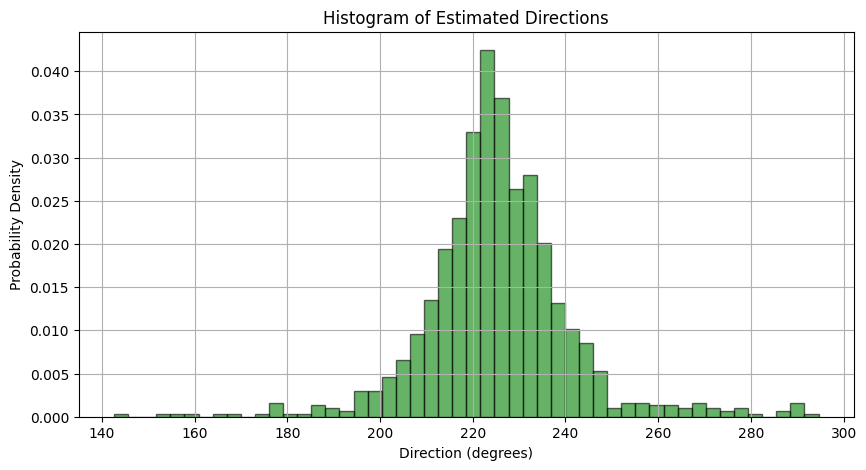

In [26]:
# Example usage
kappa = 33.3  # Example concentration parameter
motion_coherence = 0.12  # Example coherence level
directions_rad = generate_von_mises_data(kappa, num_trials, mean_direction_deg)

estimates = switching_model(directions_rad, motion_coherence, mean_direction_rad, kappa)

# Plot the estimated directions
plt.figure(figsize=(10, 5))
plt.hist(estimates, bins=50, density=True, alpha=0.6, color='g', edgecolor='black')
plt.xlabel('Direction (degrees)')
plt.ylabel('Probability Density')
plt.title('Histogram of Estimated Directions')
plt.grid(True)
plt.show()

In [ ]:
#@title Fit Models to Human Data
'''
# Example function to calculate Mean Squared Distance
def mean_squared_distance(estimates, human_data):
    return np.mean((estimates - human_data) ** 2)

# human_data = ...

# Fit and compare models
estimates_switching = switching_model(directions_deg, motion_coherence[0])

msd_switching = mean_squared_distance(estimates_switching, human_data)

print(f"Mean Squared Distance for Switching Model: {msd_switching}")
'''